### Let's write an elementary tokenizer that uses words as tokens.

We will use Mark Twain's _Life On The Mississippi_ as a test bed. The text is in the accompanying file 'Life_On_The_Mississippi.txt'

Here's a not-terribly-good such tokenizer:

In [1]:
# wdict = {}
# with open('Life_On_The_Mississippi.txt', 'r') as L:
#     line = L.readline()
#     nlines = 1
#     while line:
#         words = line.split()
#         for word in words:
#             if wdict.get(word) is not None:
#                 wdict[word] += 1
#             else:
#                 wdict[word] = 1
#         line = L.readline()
#         nlines += 1

# nitem = 0 ; maxitems = 100
# for item in wdict.items():
#     nitem += 1
#     print(item)
#     if nitem == maxitems: break


This is unsatisfactory for a few reasons:

* There are non-ASCII (Unicode) characters that should be stripped (the so-called "Byte-Order Mark" or BOM \ufeff at the beginning of the text);

* There are punctuation marks, which we don't want to concern ourselves with;

* The same word can appear capitalized, or lower-case, or with its initial letter upper-cased, whereas we want them all to be normalized to lower-case.

Part 1 of this assignment: insert code in this loop to operate on the str variable 'line' so as to fix these problems before 'line' is split into words.

A hint to one possible way to do this: use the 'punctuation' character definition in the Python 'string' module, the 'maketrans' and 'translate' methods of Python's str class, to eliminate punctuation, and the regular expression ('re') Python module to eliminate any Unicode---it is useful to know that the regular expression r'[^\x00-x7f]' means "any character not in the vanilla ASCII set.

Part 2: Add code to sort the contents of wdict by word occurrence frequency.  What are the top 100 most frequent word tokens?  Adding up occurrence frequencies starting from the most frequent words, how many distinct words make up the top 90% of word occurrences in this "corpus"?

For this part, the docs of Python's 'sorted' and of the helper 'itemgetter' from 'operator' reward study.

Write your modified code in the cell below.

Solution

In [2]:
import re, string, operator
wdict = {}
with open('Life_On_The_Mississippi.txt', 'r') as L:
    lines = L.readlines()
ttable = str.maketrans("", "", string.punctuation) #to map every punctuation to None
for line in lines:
    line = line.translate(ttable) #remove punctuation
    line = re.sub(r'[^\x00-\x7f]', r'', line).lower() #remove non-ascii chars and make all chars lowercase
    for word in line.split():
        if wdict.get(word) is not None:
            wdict[word] += 1
        else:
            wdict[word] = 1
num_words = sum(list(wdict.values()))     
print(f"Total num_words in the text: {num_words}")
print(f"Total unique words: {len(wdict)}")

#sort the dictionary in descending order of the values
wdict = dict(sorted(wdict.items(), key=operator.itemgetter(1), reverse=True))

print("Top 100 most frequent tokens:")
nitem = 0 ; maxitems = 100
for item in wdict.items():
    nitem += 1
    print(item)
    if nitem == maxitems: break
    
    
cut_off = int(0.9*num_words)
num_words_encountered = 0
top_90_percent = {}
for token, freq in wdict.items():
    if num_words_encountered < cut_off:
        if top_90_percent.get(token) is None:
            top_90_percent[token] = 1
        num_words_encountered += freq
    else:
        break
print(f"{len(top_90_percent)} most frequent tokens makeup 90% of the total words in the text")
print(list(top_90_percent.keys()))

Total num_words in the text: 147420
Total unique words: 14462
Top 100 most frequent tokens:
('the', 9255)
('and', 5892)
('of', 4532)
('a', 4053)
('to', 3592)
('in', 2593)
('it', 2293)
('i', 2205)
('was', 2093)
('that', 1724)
('he', 1402)
('is', 1148)
('for', 1095)
('with', 1081)
('you', 1033)
('his', 961)
('had', 961)
('but', 952)
('on', 947)
('as', 881)
('this', 781)
('they', 758)
('at', 750)
('not', 722)
('all', 720)
('by', 713)
('one', 686)
('there', 627)
('were', 625)
('be', 617)
('my', 582)
('or', 581)
('from', 577)
('have', 571)
('out', 541)
('so', 536)
('up', 529)
('him', 523)
('we', 519)
('me', 516)
('when', 505)
('would', 478)
('which', 476)
('river', 457)
('an', 440)
('them', 425)
('no', 422)
('then', 405)
('said', 399)
('are', 387)
('if', 381)
('their', 378)
('now', 369)
('about', 346)
('time', 337)
('been', 335)
('down', 328)
('its', 323)
('could', 313)
('has', 305)
('will', 301)
('into', 300)
('what', 285)
('her', 278)
('two', 273)
('do', 271)
('other', 270)
('some', 269)


Solution to part 2

In [3]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import sys
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [100, 60]

# Load BERT.
model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking')
# Set the model to eval mode.
model.eval()
# This notebook assumes CPU execution. If you want to use GPUs, put the model on cuda and modify subsequent code blocks.
#model.to('cuda')
# Load tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')

# Save the BERT vocabulary to a file -- by default it will name this file "vocab.txt".
tokenizer.save_vocabulary(save_directory='.')

print("The vocabulary size is: ", model.config.vocab_size) # Size of the vocabulary


The vocabulary size is:  30522


In [4]:
# Get BERT's vocabulary embeddings.
wordembs = model.get_input_embeddings()

# Convert the vocabulary embeddings to numpy.
allinds = np.arange(0,model.config.vocab_size,1)
inputinds = torch.LongTensor(allinds)
bertwordembs = wordembs(inputinds).detach().numpy()
print(bertwordembs.shape)

(30522, 1024)


In [5]:
# Read in the vocabulary
filename = "vocab.txt"
with open(filename,'r') as f:
    bertwords = np.array([])
    for line in f:
        bertwords = np.append(bertwords, line.rstrip())

# Determine vocabulary to use for t-SNE/visualization. The indices are hard-coded based partially on inspection:
bert_char_indices_to_use = np.arange(999, 1063, 1)
bert_voc_indices_to_plot = np.append(bert_char_indices_to_use, np.arange(1996, 5932, 1))
bert_voc_indices_to_use = np.append(bert_char_indices_to_use, np.arange(1996, 11932, 1))

bert_voc_indices_to_use_tensor = torch.LongTensor(bert_voc_indices_to_use)
bert_word_embs_to_use = wordembs(bert_voc_indices_to_use_tensor).detach().numpy()
bert_words_to_plot = bertwords[bert_voc_indices_to_plot]

print(len(bert_voc_indices_to_plot))
print(len(bert_voc_indices_to_use))

4000
10000


In [6]:
# Run t-SNE on the BERT vocabulary embeddings we selected:
mytsne_words = TSNE(n_components=2,early_exaggeration=12,verbose=2,metric='cosine',init='pca',n_iter=2500)
bert_word_embs_to_use_tsne = mytsne_words.fit_transform(bert_word_embs_to_use)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 1.435s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.267747
[t-SNE] Computed conditional probabilities in 0.163s
[t-SNE] Iteration 50: error = 97.8638535, gradient norm = 0.0069553 (50 iterations in 0.736s)
[t-SNE] It

In [7]:
#select 10 random words from the vocabulary
example_words_indices = np.random.choice(bert_voc_indices_to_use, 12)
example_words = bertwords[example_words_indices]
print(example_words)

['sandwich' 'nurses' 'creation' 'bigger' 'invited' 'acres' 'consistently'
 'istanbul' 'them' 'permission' 'thereby' 'average']


Let us look at the nearest neighbors of certain words to gain some insight into the semantic meaning of the embedding

In [8]:
%matplotlib inline
all_words = bertwords[bert_voc_indices_to_use]
all_embedding = bert_word_embs_to_use_tsne
def plot(word):
    word_embedding = all_embedding[np.where(all_words == word)]
    k = 20
    #obtain the k nearest neighbors in the embedding
    diff = np.linalg.norm(all_embedding - word_embedding, axis=1)
    neighbor_indices = np.argsort(diff)
    print(all_words[neighbor_indices[:k+1]])
    fig, ax = plt.subplots(dpi=100, figsize=(10, 10))
    ax.set_title(f'{k} nearest neighbors of the token: "{word}"')
    for count, i in enumerate(neighbor_indices[:k+1]):
        if count==0:
            color = 'b'; zorder=2
        else:
            color = 'grey'; zorder=0

        plt.scatter(all_embedding[i,0], all_embedding[i,1], s=1, color=color)
        plt.text(all_embedding[i,0], all_embedding[i,1], all_words[i],  family='sans-serif',fontsize=12, color=color, zorder=zorder)
    # fig.savefig('test.png')
    plt.show(fig)    
    print('\n\n')

['test' 'tests' 'testing' 'tested' 'trials' 'trial' 'survey' 'studies'
 'checked' 'checking' 'check' 'study' 'measurements' 'studying'
 'measurement' 'studied' 'measures' 'measure' 'exam' 'measuring'
 'assessment']


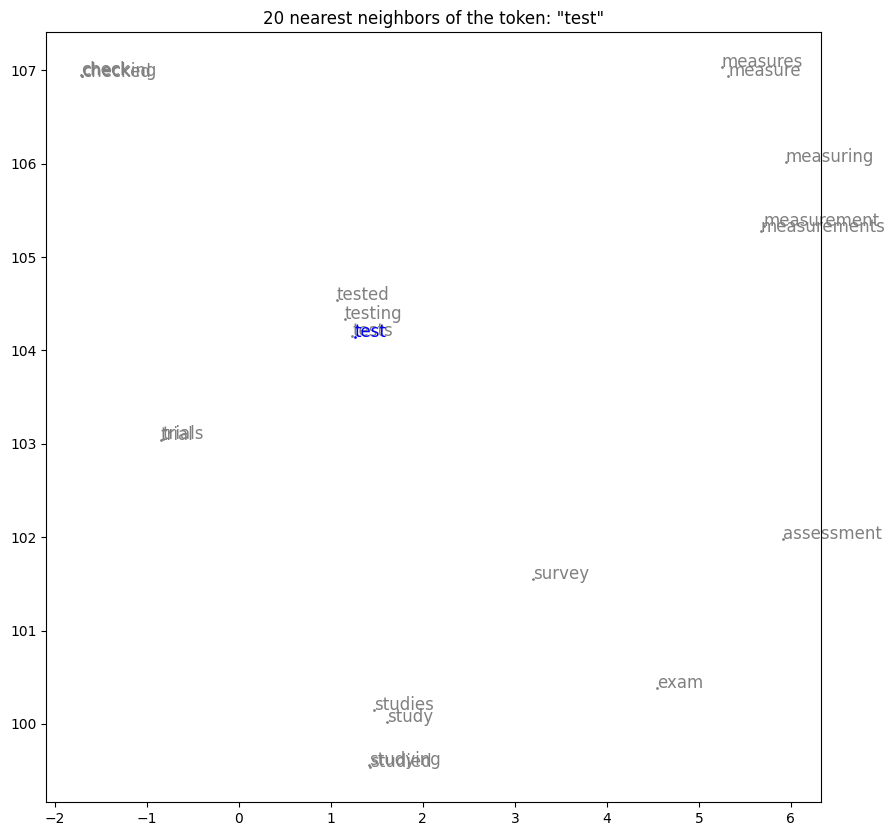




['ball' 'balls' '##ball' 'bat' 'batting' 'bowling' 'polo' 'lance' 'bolt'
 'chess' 'golf' 'arrow' 'tennis' 'cricket' 'knight' 'knights' 'poker'
 'archer' 'soccer' 'rugby' 'volleyball']


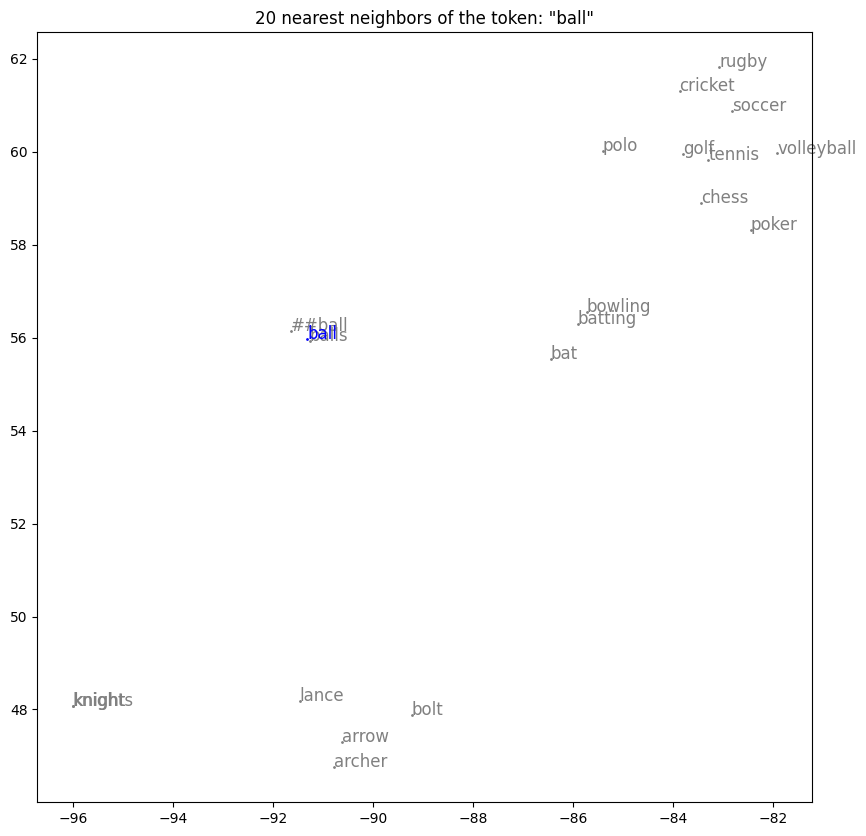




['5' '6' '4' '7' '3' '8' '2' '9' '1' '0' '12' 'zero' '13' '11' '14' '10'
 '17' '18' '16' '15' 'nine']


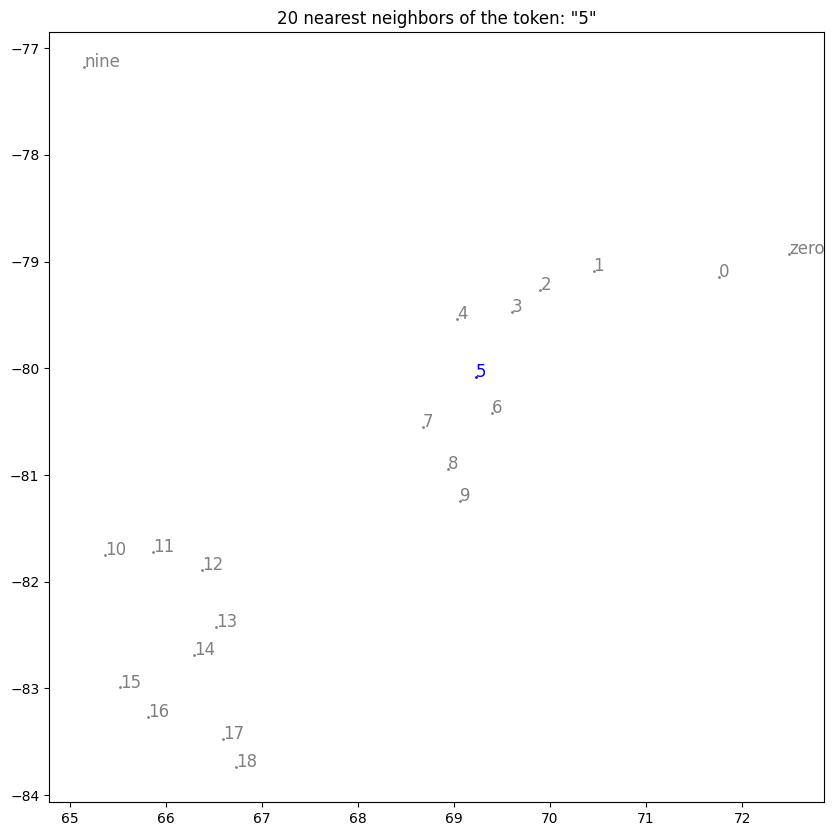




['apple' 'fruit' 'fruits' 'cherry' 'candy' 'chocolate' 'seeds' 'seed'
 'honey' 'soap' 'sugar' 'cream' 'salt' 'hatch' 'juice' 'milk' 'flowering'
 'dairy' 'eggs' 'pepper' 'egg']


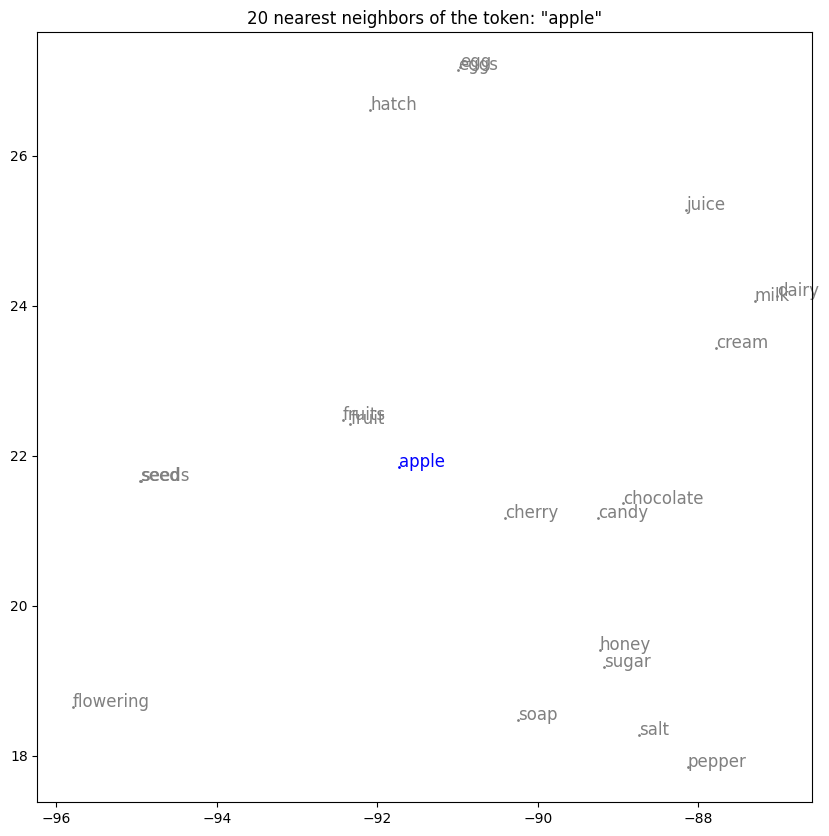




['france' 'french' 'paris' 'lyon' 'franco' 'english' 'anglo' 'holland'
 'luxembourg' 'london' 'belgian' 'belgium' 'england' 'netherlands'
 'british' 'dutch' 'britain' 'brussels' 'uk' 'swiss' 'amsterdam']


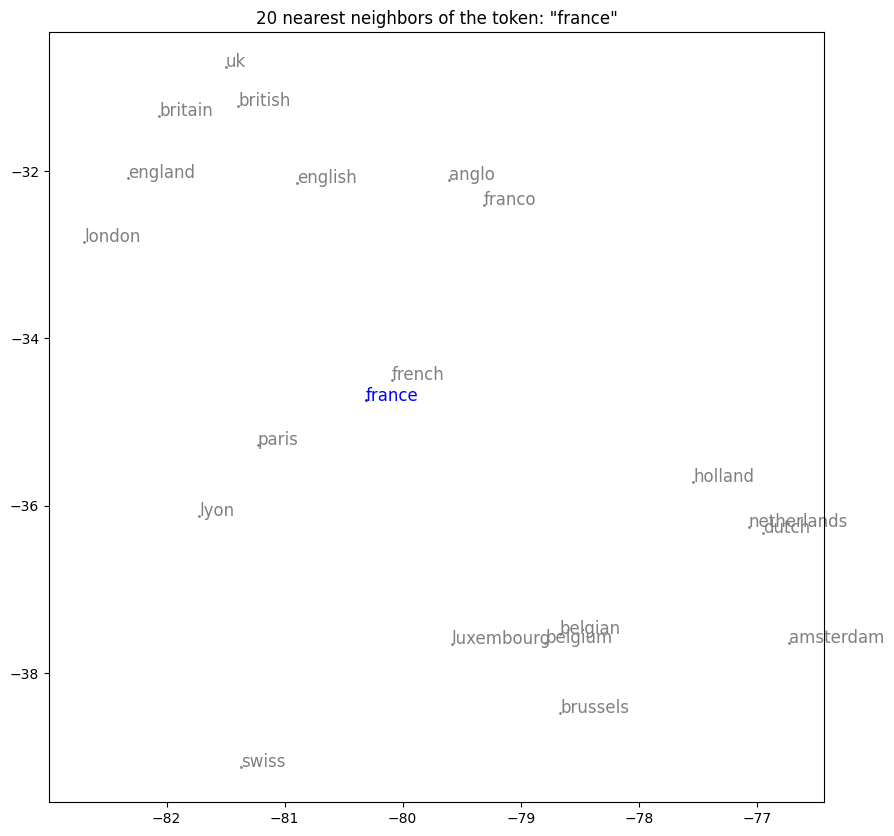

In [9]:
for word in ['test', 'ball', '5', 'apple', 'france']:
    plot(word)